# Tentando entender o que afeta os coeficientes da regressão logística

Ver o impacto de um fator multiplicativo em uma variável de entrada e de ruído

#### Meu pensamento inicial:
> - fator multiplicativo afeta coeficientes (ex.: converção de moeda: R$->US$)
> - ruído não afeta os coeficientes*

*assumindo que a média do ruído é zero e forçando que o ruído não desnormalize os dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
sns.set()

In [2]:
# Função para aplicar o ruído
def aplly_noise(noise_intensity=1):
  def func(input):
    noise_amplitude = noise_intensity*math.sin(input*math.pi)/4
    noise = np.random.uniform(-noise_amplitude,noise_amplitude)
    return input+noise
  return func

In [3]:
# "intensidade" dos ruídos
noise_levels = {
  'noised_a': 0.33333,
  'noised_b': 0.66667,
  'noised_c': 1,
}

# dataframe com entrada pura, com diferentes níveis de ruído, entrada aleatória e saída esperada
df = pd.DataFrame()
df['inputs'] = np.linspace(0,1,10000)
df['noised_a'] = df['inputs'].map(aplly_noise(noise_levels['noised_a']))
df['noised_b'] = df['inputs'].map(aplly_noise(noise_levels['noised_b']))
df['noised_c'] = df['inputs'].map(aplly_noise(noise_levels['noised_c']))
df['random'] = np.random.uniform(0,1, len(df['inputs']))
df['outputs'] = df['inputs'].map(lambda input: 0 if input<0.5 else 1)

# primeiras e ultimas linhas para ilustrar
df.take([0,1,-2,-1])

,inputs,noised_a,noised_b,noised_c,random,outputs
0,0.0000,0.000000,0.000000,0.000000,0.347951,0
1,0.0001,0.000098,0.000089,0.000130,0.729484,0
9998,0.9999,0.999912,0.999872,0.999904,0.203812,1
9999,1.0000,1.000000,1.000000,1.000000,0.986821,1


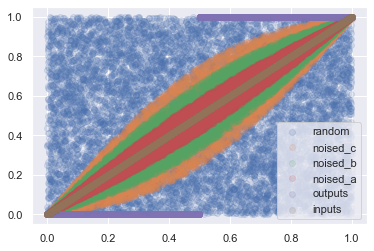

In [4]:
# Dispersão de todas as colunas do dataframe

fig, ax = plt.subplots()
ax.scatter(x=df.inputs, y=df.random, label="random", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_c, label="noised_c", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_b, label="noised_b", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_a, label="noised_a", alpha=.15)
ax.scatter(x=df.inputs, y=df.outputs, label="outputs", alpha=.15)
ax.scatter(x=df.inputs, y=df.inputs, label="inputs", alpha=.15)
ax.legend()

# 🤔 Pra que tudo isso?
- `inputs`: entrada ideal para determinar os `outputs`
- `noised_X`: variações do `inputs` com algum ruído. Ruído se intensifica apenas no centro para evitar a "desnormalização" dos dados (mesmo com o ruído, tudo fica entre 0 e 1)
- `inputs`: entrada aleatória que não deve apresentar correlação com `outputs`

### Regrassão com `inputs`:

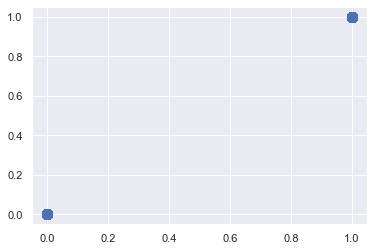

In [5]:
X = df[['inputs']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs = (clf.coef_[0][0], clf.intercept_[0])
plt.scatter(x=y, y=y_pred, s=100)

> regressão perfeita, nenhum falso positivo ou falso negativo

### Regrassão com `noised_a`:

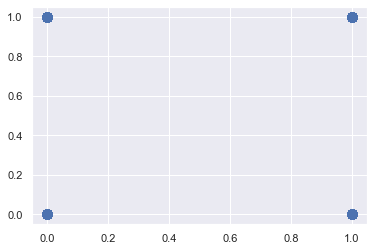

In [6]:
X = df[['noised_a']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

noised_a_coefs = (clf.coef_[0][0], clf.intercept_[0])
plt.scatter(x=y, y=y_pred, alpha=0.01, s=100)

> regressão imperfeita, alguns falsos positivos e falsos negativos

# Comparando os coeficientes isolados

In [7]:
print('input_coefs:',input_coefs)
print('noised_a_coefs:',noised_a_coefs)

input_coefs: (25.430619174690186, -12.71529402057659)
noised_a_coefs: (21.70734813495863, -10.853287081588034)


### Conclusão1: Meu pensamento inicial estava errado.
O ruido afetou o coeficiente

# Vendo os coeficientes usando todas as variáveis

In [8]:
X = df[['inputs','noised_a','noised_b','noised_c','random']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

pd.DataFrame(clf.coef_, columns=X.columns)

,inputs,noised_a,noised_b,noised_c,random
0,16.526663,9.558946,5.117222,2.454596,0.043821


# Vendo o efeito do fator multiplicativo em uma das entradas

In [9]:
X = df[['inputs','noised_a','noised_b','noised_c','random']].copy()
X['noised_a'] = X['noised_a'].map(lambda vals: vals/10)
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

pd.DataFrame(clf.coef_, columns=X.columns)

,inputs,noised_a,noised_b,noised_c,random
0,20.740161,2.014887,5.795892,2.872871,0.023844


In [10]:
X = df[['inputs','noised_a','noised_b','noised_c','random']].copy()
X['noised_a'] = X['noised_a'].map(lambda vals: vals*10)
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

pd.DataFrame(clf.coef_, columns=X.columns)

,inputs,noised_a,noised_b,noised_c,random
0,12.944436,2.231919,4.767061,2.205989,0.063993


# Vendo o efeito do fator multiplicativo em uma das entradas em casos isolados

In [30]:
X = df[['inputs']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs = (clf.coef_[0][0], clf.intercept_[0])

In [41]:
X = df[['inputs']].copy()
X.inputs = X.inputs*1000
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs_1000 = (clf.coef_[0][0], clf.intercept_[0])

#### Comparando os coeficientes

In [42]:
print("Com entrada original:",input_coefs)
print("Entrada multiplicada:",input_coefs_1000)

Com entrada original: (25.430619174690186, -12.71529402057659)
Entrada multiplicada: (2.544529425667609, -1272.2647617800062)
